# Import

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
import random
import numpy as np
import scipy
from scipy.optimize import linprog
from mpl_toolkits.mplot3d import Axes3D
from math import inf
from math import ceil
import warnings
warnings.filterwarnings("ignore")
import time

In [2]:
!pip install mip
from mip import Model, xsum, minimize, BINARY

#Brute Force

In [3]:
def check_if_vertex_cover(graph, subset):
    '''
    graph is dict {1:[2,3,4], 2: [1,3,4,5]}
    subset is a list [5,6,7,8]
    '''
    for vertex in graph.keys():
        if vertex in subset:
            continue
        for adjacent_vertex in graph[vertex]:
            if adjacent_vertex not in subset:
                return False

    return True 

class Brute:
    minSize=100000
    vertex_cover=[]
    all_vertex_covers = []

def subsetsUtil(A, subset, index, graph, trk, ALL = "No"): 
    
    if ALL == "No":
        if check_if_vertex_cover(graph,subset):
            if len(subset) < trk.minSize:
                trk.minSize = len(subset)
                trk.vertex_cover = subset[:]
    elif ALL == "Yes":
        if check_if_vertex_cover(graph,subset):
            if len(subset) < trk.minSize:
                trk.minSize = len(subset)
                trk.vertex_cover = subset[:]
                trk.all_vertex_covers.clear()
                trk.all_vertex_covers.append(trk.vertex_cover)
            elif len(subset) == trk.minSize:
                trk.vertex_cover = subset[:]
                trk.all_vertex_covers.append(trk.vertex_cover)

    for i in range(index, len(A)):  
        subset.append(A[i])
        subsetsUtil(A, subset, i + 1, graph, trk, ALL)  
        subset.pop(-1)  
    return

def subsets(A, graph, trk, ALL = "No"):
    subset = [] 
    index = 0
    subsetsUtil(A, subset, index, graph, trk, ALL)  

def brute_force(graph_object, ALL = "No"): 
    brut = Brute()
    graph = nx.to_dict_of_lists(graph_object)
    array = [x for x in graph.keys()] 
    subsets(array, graph, brut, ALL) 
    if ALL == "No":
        return brut.vertex_cover
    else:
        return brut.all_vertex_covers

In [4]:
def plot_graph(graph_object):
    plt.subplot(121)
    nx.draw(graph_object, with_labels=True, font_weight='bold')

# Approx Algo

## Maximal Matching Algo

In [5]:
def mm_algo(graph_object):
    # Set of edges
    maximal_matching = nx.max_weight_matching(graph_object)
    C = []
    for edge in maximal_matching:
        C.append(edge[0])
        C.append(edge[1])

    return C

## G1 Algorithm

In [6]:
def g1_algo(graph_object):
    vertex_cover = []
    graph = nx.to_dict_of_lists(graph_object)
    for vertex,adj_vertices in graph.items():
        if len(adj_vertices) != 0:
            vertex_cover.append(vertex)    
            for adj_vertex in adj_vertices:
                if vertex in graph[adj_vertex]:
                    graph[adj_vertex].remove(vertex)

    return vertex_cover

## G2 Algorithm

In [7]:
def g2_algo(graph_object):
    vertex_cover = []
    graph = nx.to_dict_of_lists(graph_object)
    # Sort graph according to size of item:
    sorted_keys = sorted(graph, key=lambda k: len(graph[k]), reverse=True)
    for vertex in sorted_keys:
        if len(graph[vertex]) != 0:
            vertex_cover.append(vertex)    
            for adj_vertex in graph[vertex]:
                if vertex in graph[adj_vertex]:
                    graph[adj_vertex].remove(vertex)

    return vertex_cover

## RA Algorithm

In [8]:
def ra_algo(graph_object):
    vertex_cover = []
    edges = list(graph_object.edges())
    while len(edges) > 0:
        # Pick u,v uniformly
        pick_prob = random.random()
        if (pick_prob >= 0.5):
            vertex = edges[0][0]
        else:
            vertex = edges[0][1]
        vertex_cover.append(vertex)
        edges = [edge for edge in edges if vertex not in edge]
    return vertex_cover

In [9]:
def multiple_ra_algo(graph_object,RUNS = 30,PRINT = False):
    vertex_cover_lengths = 0
    info = []
    for i in range(RUNS):
        vertex_cover = ra_algo(graph_object)
        vertex_cover_lengths += len(vertex_cover)
        info.append(len(vertex_cover))
    avg = vertex_cover_lengths/RUNS
    std_dev = np.std(np.array(info))
    
    if PRINT:
        plt.plot(info)
        plt.title("Length vs Runs")
        plt.xlabel("Number of Runs")
        plt.ylabel("Length of Vertex Cover")
        print("Standard Deviation:",std_dev)
        print("Average over",RUNS,"Runs:",avg,"\n")
    return avg,std_dev

# Comparision of Approx Algos using Brute Force

## Ratios of Vertex Covers

In [10]:
def compare(graph_object, RUNS_FOR_RA = 30, PRINT = False, lp = "none", TIME = False):
    t_brute_start = time.time()
    if lp == "rlp":
        vertex_cover_brute = rlp(graph_object, [])
    elif lp == "ilp":
        vertex_cover_brute = ilp(graph_object, [])
    else:
        vertex_cover_brute = brute_force(graph_object)
    t_brute_end = time.time()

    t_g1_start = time.time()
    vertex_cover_g1 = g1_algo(graph_object)
    t_g1_end = time.time()
    t_g2_start = time.time()
    vertex_cover_g2 = g2_algo(graph_object)
    t_g2_end = time.time()
    t_mm_start = time.time()
    vertex_cover_mm = mm_algo(graph_object)
    t_mm_end = time.time()
    t_ra_start = time.time()
    vertex_cover_ra = ra_algo(graph_object)
    t_ra_end = time.time()

    t_brute = t_brute_end - t_brute_start
    t_g1 = t_g1_end - t_g1_start
    t_g2 = t_g2_end - t_g2_start
    t_mm = t_mm_end - t_mm_start
    t_ra = t_ra_end - t_ra_start
    
    if TIME == True:
        time_dict = {'brute':t_brute,'g1':t_g1,'g2':t_g2,'mm':t_mm,'ra':t_ra}
        return time_dict

    if len(vertex_cover_brute) == 0:
        return {'g1':0,'g2':0,'mm':0,'ra':0} 
    g1_ratio = len(vertex_cover_g1)/len(vertex_cover_brute)
    g2_ratio = len(vertex_cover_g2)/len(vertex_cover_brute)
    mm_ratio = len(vertex_cover_mm)/len(vertex_cover_brute)
    len_vertex_cover_ra,std_dev_ra = multiple_ra_algo(graph_object,RUNS_FOR_RA)
    ra_ratio = len_vertex_cover_ra/len(vertex_cover_brute)

    if (PRINT):
        info = {}
        info["Vertex Covers"] = [vertex_cover_brute,vertex_cover_g1,vertex_cover_g2,vertex_cover_mm,vertex_cover_ra] 
        info["Length"] = [len(vertex_cover_brute),len(vertex_cover_g1),len(vertex_cover_g2),len(vertex_cover_mm),len(vertex_cover_ra)]
        info["Ratio wrt Brute Force"] = [1,g1_ratio,g2_ratio,mm_ratio,ra_ratio]
        df = pd.DataFrame.from_dict(info)

        if lp == "rlp":
            df.index = ["Relaxed Lin Prog","G1 Algo","G2 Algo","MM Algo","RA Algo"]
        elif lp == "ilp":
            df.index = ["Integer Lin Prog","G1 Algo","G2 Algo","MM Algo","RA Algo"]
        else:
            df.index = ["Brute Force","G1 Algo","G2 Algo","MM Algo","RA Algo"]
        df.index.name = "Algorithms"
        plot_graph(graph_object)
        print("----------------------------------Comparision of Algorithms----------------------------------")
        print(tabulate(df,headers='keys',tablefmt="github"))
        print("---------------------------------------------------------------------------------------------")

    ratio_dict = {'g1':g1_ratio,'g2':g2_ratio,'mm':mm_ratio,'ra':ra_ratio}
    return ratio_dict

----------------------------------Comparision of Algorithms----------------------------------
| Algorithms   | Vertex Covers                          |   Length |   Ratio wrt Brute Force |
|--------------|----------------------------------------|----------|-------------------------|
| Brute Force  | [2, 3, 4, 5, 9, 10, 11]                |        7 |                 1       |
| G1 Algo      | [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]         |       10 |                 1.42857 |
| G2 Algo      | [9, 0, 3, 2, 4, 5, 10, 7, 8]           |        9 |                 1.28571 |
| MM Algo      | [11, 7, 9, 3, 10, 6, 1, 5, 0, 2, 8, 4] |       12 |                 1.71429 |
| RA Algo      | [0, 1, 3, 2, 4, 6, 5, 9, 7, 8]         |       10 |                 1.38095 |
---------------------------------------------------------------------------------------------


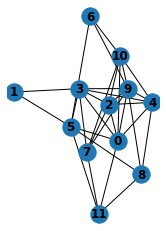

In [11]:
example_n = 12
example_p = 0.5
example_seed = 1203
example_directed = False
example_graph_object = nx.gnp_random_graph(example_n, example_p, example_seed, example_directed)
example_graph = nx.to_dict_of_lists(example_graph_object)
_ = compare(example_graph_object, RUNS_FOR_RA = 30, PRINT = True, lp = "none")

One Run of RA Algo: [0, 3, 5, 4, 7, 2, 6, 9, 8] 

Standard Deviation: 0.752034278178565
Average over 30 Runs: 9.633333333333333 



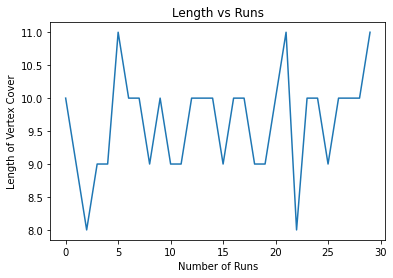

In [12]:
print("One Run of RA Algo:",ra_algo(example_graph_object),"\n")
_,_ = multiple_ra_algo(example_graph_object, RUNS = 30, PRINT = True)

In [13]:
def plot_ratios(wrt,ratios,lst,ax,title = "Ratio of Length of Vertex Cover"):
    ratios[wrt] = lst
    df = pd.DataFrame.from_dict(ratios)
    df.columns = df.columns.str.strip()
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    print("\n",title,"vs",wrt)
    print("-----------------------------------------------")
    print(tabulate(df, headers='keys', showindex = False, tablefmt="github"))
    del ratios[wrt]
    
    for key in ratios.keys():
        ax.plot(ratios[key], label=key) 
    plt.sca(ax)
    ax.set_xlabel(wrt)
    ax.set_ylabel(title)
    ax.set_title(title+" vs "+wrt)
    plt.xticks(list(range(len(lst))), [ceil(100*x)/100 for x in lst])
    
def plot_3d(title,ps,ns,Z,ax,z_max):
    X, Y = np.meshgrid(ps, ns)  
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_title(title);   
    ax.set_xlabel('P')
    ax.set_ylabel('N')
    ax.set_zlabel('Ratio')
    ax.set_zlim(0, z_max)
    ax.view_init(30, 50)

In [14]:
def compare_n_p_plot(n_start,n_end,p_start,p_end,p_increment,lp = "none",COMPARE = "size"):
   
    ns = []
    g1_ratios = []
    g2_ratios = []
    mm_ratios = []
    ra_ratios = []
    brute_ratios = []

    for n in range(n_start,n_end+1):
        p = p_start
        g1_ratios_p = []
        g2_ratios_p = []
        mm_ratios_p = []
        ra_ratios_p = []
        brute_ratios_p = []
        while (p <= p_end+0.01):
            g1_ratio_sum = 0
            g2_ratio_sum = 0
            mm_ratio_sum = 0
            ra_ratio_sum = 0
            brute_ratio_sum = 0
            no = 0
            for seed in range(1,11):
                graph_object = nx.gnp_random_graph(n, p, seed, directed = False)
                if COMPARE == "size":
                    ratios = compare(graph_object,RUNS_FOR_RA = 30,PRINT = False, lp = lp)
                    g1_ratio = ratios['g1']
                    g2_ratio = ratios['g2']
                    mm_ratio = ratios['mm']
                    ra_ratio = ratios['ra']
                elif COMPARE == "hamming":
                    g1_ratio,g2_ratio,mm_ratio,ra_ratio = compare_hamming_distances(graph_object,PRINT = False)
                elif COMPARE == "time":
                    ratios = compare(graph_object,RUNS_FOR_RA = 1,PRINT = False, lp = lp, TIME = True)
                    g1_ratio = ratios['g1']
                    g2_ratio = ratios['g2']
                    mm_ratio = ratios['mm']
                    ra_ratio = ratios['ra']
                    brute_ratio = ratios['brute']
                 
                g1_ratio_sum += g1_ratio
                g2_ratio_sum += g2_ratio
                mm_ratio_sum += mm_ratio
                ra_ratio_sum += ra_ratio
                if COMPARE == "time":
                    brute_ratio_sum += brute_ratio
                if (g1_ratio != 0 or COMPARE == "hamming"):
                    no += 1
            p += p_increment
            g1_ratios_p.append(g1_ratio_sum/no)
            g2_ratios_p.append(g2_ratio_sum/no)
            mm_ratios_p.append(mm_ratio_sum/no)
            ra_ratios_p.append(ra_ratio_sum/no)
            brute_ratios_p.append(brute_ratio_sum/no)
        ns.append(n)
        g1_ratios.append(g1_ratios_p)
        g2_ratios.append(g2_ratios_p)
        mm_ratios.append(mm_ratios_p)
        ra_ratios.append(ra_ratios_p)
        brute_ratios.append(brute_ratios_p)

    ps = np.linspace(0.05, 1, num = 20)
    g1_ratios = np.array(g1_ratios)
    g2_ratios = np.array(g2_ratios)
    mm_ratios = np.array(mm_ratios)
    ra_ratios = np.array(ra_ratios)

    g1_ratios_p = np.sum(g1_ratios,axis=0)/len(g1_ratios)
    g2_ratios_p = np.sum(g2_ratios,axis=0)/len(g2_ratios)
    mm_ratios_p = np.sum(mm_ratios,axis=0)/len(mm_ratios)
    ra_ratios_p = np.sum(ra_ratios,axis=0)/len(ra_ratios)
    
    g1_ratios_n = np.sum(g1_ratios,axis=1)/len(g1_ratios[0])
    g2_ratios_n = np.sum(g2_ratios,axis=1)/len(g2_ratios[0])
    mm_ratios_n = np.sum(mm_ratios,axis=1)/len(mm_ratios[0])
    ra_ratios_n = np.sum(ra_ratios,axis=1)/len(ra_ratios[0])

    if COMPARE == "time":
        brute_ratios = np.array(brute_ratios)
        brute_ratios_p = np.sum(brute_ratios,axis=0)/len(brute_ratios)
        brute_ratios_n = np.sum(brute_ratios,axis=1)/len(brute_ratios[0])

    fig = plt.figure(figsize=(20,7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ratios_p = {"g1":g1_ratios_p,"g2":g2_ratios_p,"mm":mm_ratios_p,"ra":ra_ratios_p}
    ratios_n = {"g1":g1_ratios_n,"g2":g2_ratios_n,"mm":mm_ratios_n,"ra":ra_ratios_n}
    title = "Ratio of Vertex Covers"
    if COMPARE == "time":
        ratios_p["brute"] = brute_ratios_p
        ratios_n["brute"] = brute_ratios_n
        title = "Time taken"
    elif COMPARE == "hamming":
        title = "Hamming Distance wrt Brute Force"

    plot_ratios("P",ratios_p,ps,ax1,title)
    plot_ratios("N",ratios_n,ns,ax2,title)
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels)  
    fig.show()

    no_of_plots = 4
    z_max = 2
    if COMPARE == "hamming":
        z_max = 4
    elif COMPARE == "time":
        z_max = 0.0005
        no_of_plots = 5
    fig = plt.figure(figsize=(35,6))
    ax1 = fig.add_subplot(1, no_of_plots, 1,projection='3d')
    ax2 = fig.add_subplot(1, no_of_plots, 2, projection='3d')
    ax3 = fig.add_subplot(1, no_of_plots, 3, projection='3d')
    ax4 = fig.add_subplot(1, no_of_plots, 4, projection='3d')
    if COMPARE == "time":
        ax5 = fig.add_subplot(1, no_of_plots, 5, projection='3d')
    plot_3d('G1',ps,ns,g1_ratios,ax1,z_max)
    plot_3d('G2',ps,ns,g2_ratios,ax2,z_max)
    plot_3d('MM',ps,ns,mm_ratios,ax3,z_max)
    plot_3d('RA',ps,ns,ra_ratios,ax4,z_max)
    if COMPARE == "time":
        plot_3d('Brute',ps,ns,brute_ratios,ax5,z_max)
    fig.show()


 Ratio of Vertex Covers vs P
-----------------------------------------------
|    P |      g1 |      g2 |      mm |      ra |
|------|---------|---------|---------|---------|
| 0.05 | 1.26259 | 1.03146 | 1.99028 | 1.17898 |
| 0.1  | 1.38342 | 1.0737  | 1.97375 | 1.26479 |
| 0.15 | 1.37667 | 1.11663 | 1.92347 | 1.27725 |
| 0.2  | 1.3716  | 1.10916 | 1.86347 | 1.26723 |
| 0.25 | 1.38905 | 1.10804 | 1.82081 | 1.27271 |
| 0.3  | 1.35661 | 1.12388 | 1.7602  | 1.25868 |
| 0.35 | 1.35304 | 1.11634 | 1.69722 | 1.25009 |
| 0.4  | 1.33504 | 1.11999 | 1.62724 | 1.24063 |
| 0.45 | 1.32819 | 1.11132 | 1.57834 | 1.23952 |
| 0.5  | 1.28578 | 1.11599 | 1.49883 | 1.22484 |
| 0.55 | 1.27454 | 1.11319 | 1.44866 | 1.21181 |
| 0.6  | 1.24889 | 1.10075 | 1.40625 | 1.19813 |
| 0.65 | 1.2376  | 1.09549 | 1.37487 | 1.19403 |
| 0.7  | 1.21765 | 1.07556 | 1.32912 | 1.17373 |
| 0.75 | 1.18797 | 1.07222 | 1.28616 | 1.15713 |
| 0.8  | 1.17714 | 1.06625 | 1.2623  | 1.14699 |
| 0.85 | 1.14233 | 1.05914 | 1.21656 | 1

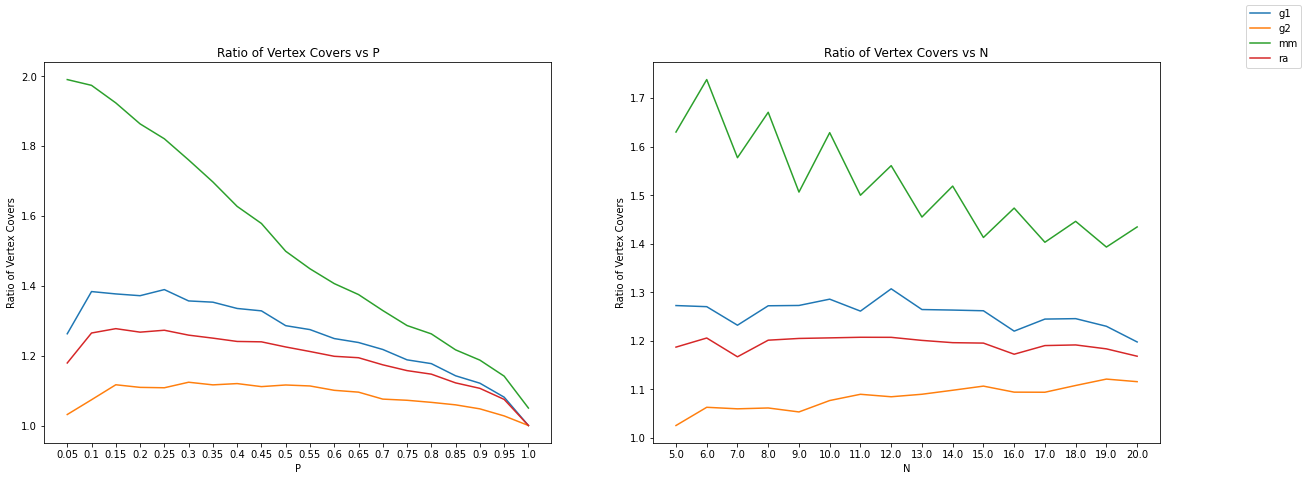

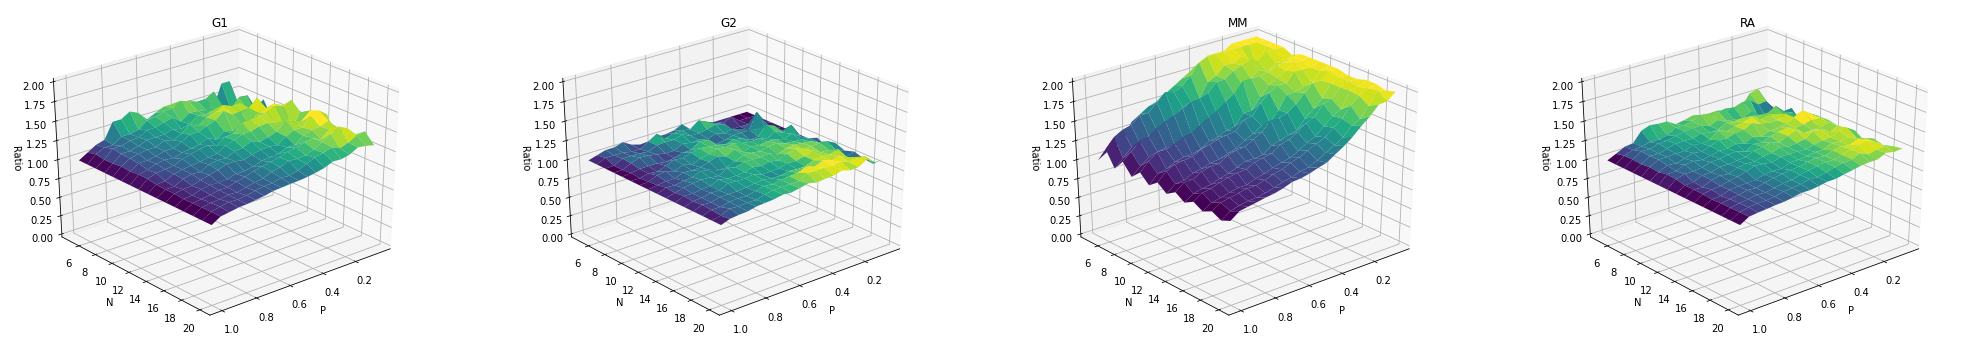

In [15]:
compare_n_p_plot(5,20,0.05,1,0.05)

## Time of various Algos


 Time taken vs P
-----------------------------------------------
|    P |          g1 |          g2 |          mm |          ra |    brute |
|------|-------------|-------------|-------------|-------------|----------|
| 0.05 | 3.36975e-05 | 2.6226e-05  | 0.000294958 | 2.63393e-05 | 0.30124  |
| 0.1  | 3.57911e-05 | 2.93195e-05 | 0.000360757 | 3.04684e-05 | 0.238217 |
| 0.15 | 3.81842e-05 | 3.06979e-05 | 0.000408372 | 3.39136e-05 | 0.221732 |
| 0.2  | 4.0625e-05  | 3.36185e-05 | 0.000461391 | 3.86626e-05 | 0.211451 |
| 0.25 | 4.30658e-05 | 3.75822e-05 | 0.00050956  | 4.22239e-05 | 0.206189 |
| 0.3  | 4.50239e-05 | 3.88697e-05 | 0.000540285 | 4.49508e-05 | 0.203288 |
| 0.35 | 4.73022e-05 | 4.18976e-05 | 0.000587499 | 4.79504e-05 | 0.200887 |
| 0.4  | 5.12823e-05 | 4.55558e-05 | 0.000635932 | 5.16534e-05 | 0.199368 |
| 0.45 | 5.75766e-05 | 4.96954e-05 | 0.000674479 | 6.0086e-05  | 0.19848  |
| 0.5  | 5.86018e-05 | 5.31808e-05 | 0.000701201 | 6.17206e-05 | 0.19749  |
| 0.55 | 5.97119e-05 |

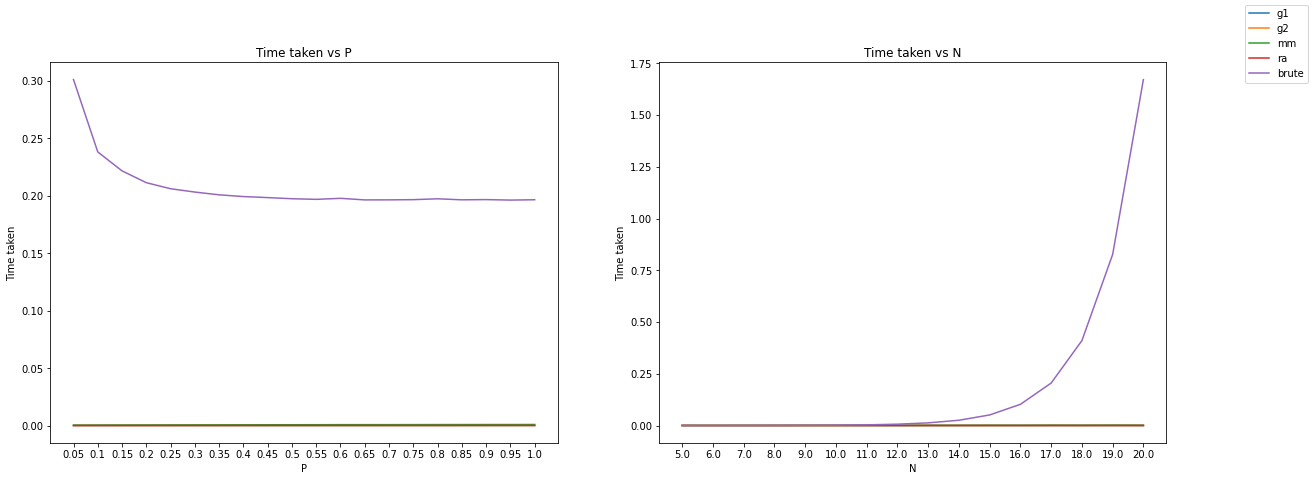

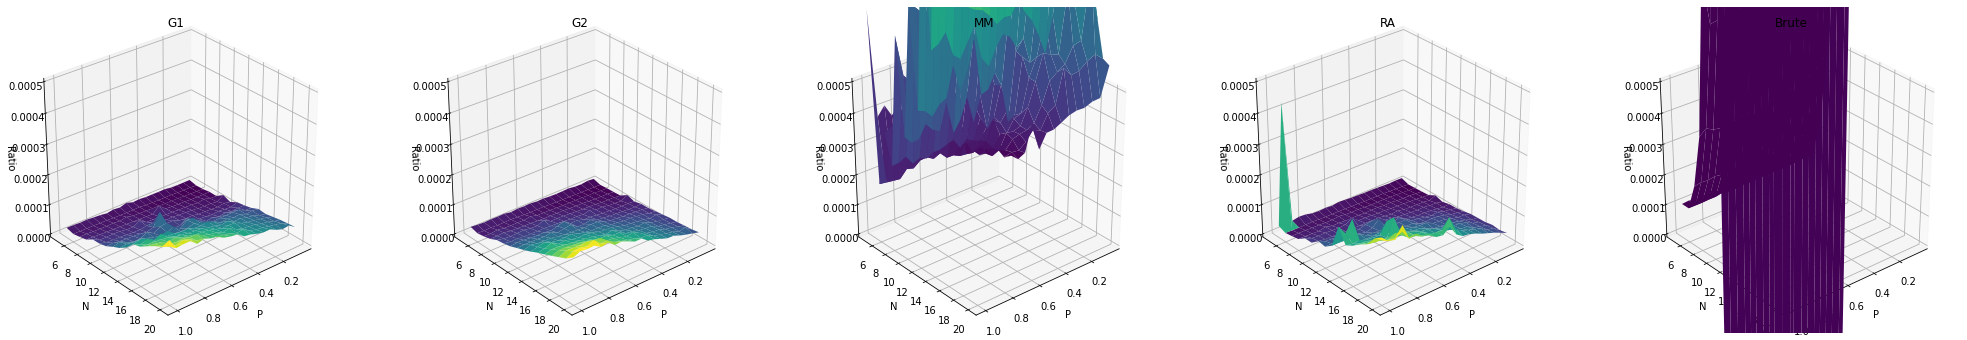

In [16]:
compare_n_p_plot(5,20,0.05,1,0.05,COMPARE = "time")

# Hamming Distance

In [17]:
'''
N = 6

G1 : 135
Brute force vertex cover : 12(ideal,smallest)

Char Vector:

010101 - G1
011000 - Brute Force
001101

HD  = 3
'''

def find_hamming_distance(vertex_cover,vertex_cover_brute):
    return len(set(vertex_cover)^set(vertex_cover_brute))

def find_min_hamming_distance_brute(vertex_cover,all_brute_vertex_covers):
    min_dist = find_hamming_distance(vertex_cover,all_brute_vertex_covers[0])
    for vertex_cover_brute in all_brute_vertex_covers:
        dist = find_hamming_distance(vertex_cover,vertex_cover_brute)
        if dist < min_dist:
            min_dist = dist

    return min_dist

def compare_hamming_distances(graph_object, PRINT = False):
    vertex_cover_g1 = g1_algo(graph_object)
    vertex_cover_g2 = g2_algo(graph_object)
    vertex_cover_mm = mm_algo(graph_object)
    vertex_cover_ra = ra_algo(graph_object)

    all_brute_vertex_covers = brute_force(graph_object,ALL = "Yes")
    
    min_vertex_cover_brute_g1 = find_min_hamming_distance_brute(vertex_cover_g1,all_brute_vertex_covers)
    min_vertex_cover_brute_g2 = find_min_hamming_distance_brute(vertex_cover_g2,all_brute_vertex_covers)
    min_vertex_cover_brute_mm = find_min_hamming_distance_brute(vertex_cover_mm,all_brute_vertex_covers)
    min_vertex_cover_brute_ra = find_min_hamming_distance_brute(vertex_cover_ra,all_brute_vertex_covers)


    if PRINT == True:
        info = {}
        info["Min Hamming Dist"] =  [min_vertex_cover_brute_g1,min_vertex_cover_brute_g2,min_vertex_cover_brute_mm,min_vertex_cover_brute_ra]
        df = pd.DataFrame.from_dict(info)
        df.index = ["G1 Algo","G2 Algo","MM Algo","RA Algo"]
        print("Comparision of Hamming Distances with Brute Force")
        print(tabulate(df,headers='keys',tablefmt="github"))
        print("---------------------------------")
    return min_vertex_cover_brute_g1,min_vertex_cover_brute_g2,min_vertex_cover_brute_mm,min_vertex_cover_brute_ra

In [18]:
example_2_n = 20
example_2_p = 0.8
example_2_seed = 1203
example_2_directed = False
example_2_graph_object = nx.gnp_random_graph(example_2_n, example_2_p, example_2_seed, example_2_directed)
example_2_graph = nx.to_dict_of_lists(example_2_graph_object)
_,_,_,_ = compare_hamming_distances(example_2_graph_object, PRINT = True)

Comparision of Hamming Distances with Brute Force
|         |   Min Hamming Dist |
|---------|--------------------|
| G1 Algo |                  2 |
| G2 Algo |                  1 |
| MM Algo |                  3 |
| RA Algo |                  2 |
---------------------------------



 Hamming Distance wrt Brute Force vs P
-----------------------------------------------
|    P |      g1 |      g2 |      mm |      ra |
|------|---------|---------|---------|---------|
| 0.05 | 1.54375 | 0.19375 | 2.975   | 1.23125 |
| 0.1  | 2.81875 | 0.5     | 4.31875 | 2.1875  |
| 0.15 | 3.54375 | 1.09375 | 4.71875 | 2.5375  |
| 0.2  | 3.64375 | 1.29375 | 4.95625 | 2.875   |
| 0.25 | 3.8375  | 1.4125  | 4.96875 | 3.08125 |
| 0.3  | 3.9125  | 1.44375 | 4.81875 | 3.1125  |
| 0.35 | 3.80625 | 1.46875 | 4.5375  | 2.90625 |
| 0.4  | 3.8     | 1.475   | 4.29375 | 3.2     |
| 0.45 | 3.86875 | 1.55625 | 4.15    | 3.19375 |
| 0.5  | 3.4625  | 1.4125  | 3.8125  | 3.11875 |
| 0.55 | 3.41875 | 1.49375 | 3.59375 | 2.9125  |
| 0.6  | 3.175   | 1.4     | 3.34375 | 2.7     |
| 0.65 | 3.19375 | 1.41875 | 3.20625 | 2.83125 |
| 0.7  | 2.925   | 1.1375  | 2.8875  | 2.38125 |
| 0.75 | 2.5625  | 1.025   | 2.73125 | 2.40625 |
| 0.8  | 2.55625 | 0.98125 | 2.58125 | 2.28125 |
| 0.85 | 2.2375  | 0.78125 | 2

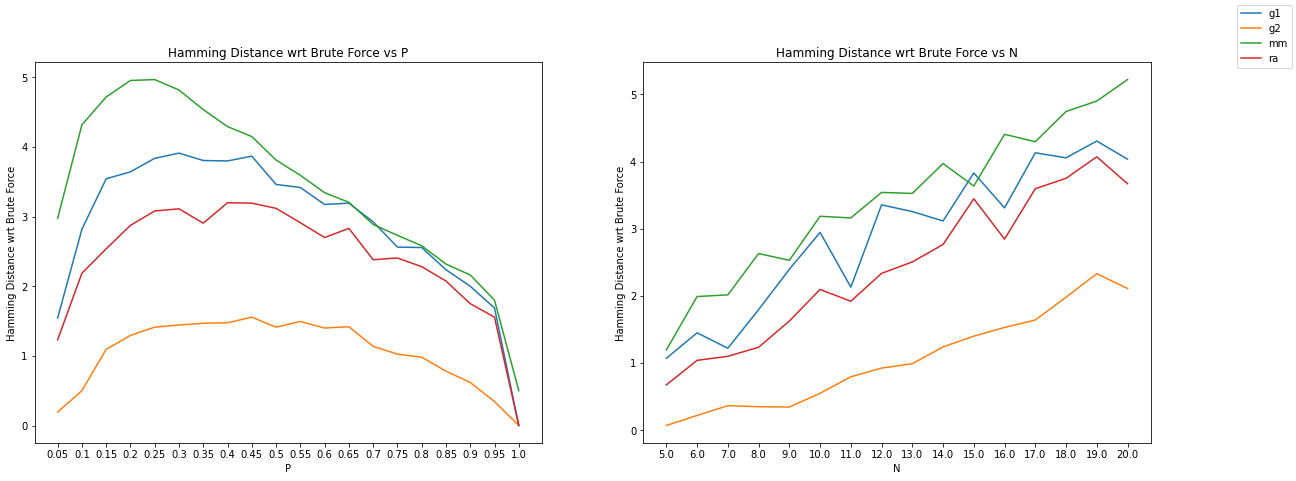

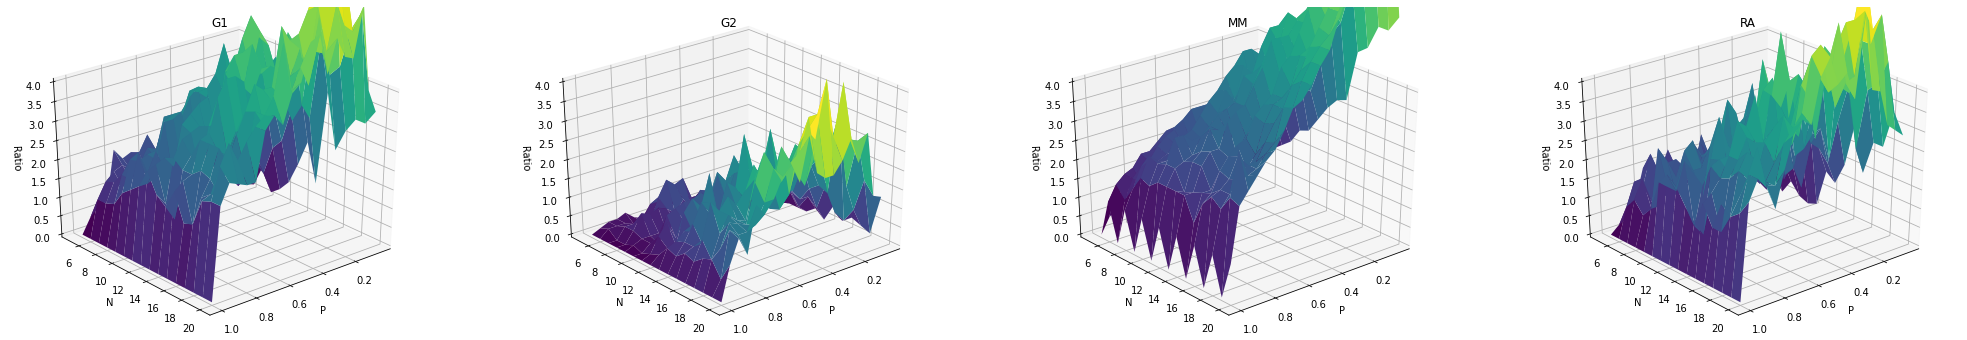

In [19]:
compare_n_p_plot(5,20,0.05,1,0.05,COMPARE = "hamming")

# Relaxed Linear Programming

In [20]:
EPSILON = 0.000001

def rlp(graph_object, obj):
    E = list(graph_object.edges())
    graph = nx.to_dict_of_lists(graph_object)
    if (len(E) == 0):
        return [],True
    n = len(graph.keys())
    #Objective function is the weights
    if len(obj)==0:
        obj = []
        for i in range(n):
            obj.append(1)

    lhs_ineq = []
    rhs_ineq = []

    for edge in E:
        arr1 = [0]*n
        arr1[edge[0]] = -1
        arr1[edge[1]] = -1
        lhs_ineq.append(arr1)
        rhs_ineq.append(-1)

    lhs_eq = []
    rhs_eq = []

    bnd = []

    for i in range(n):
        bnd.append((0,inf))
    opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd)

    vertex_in_vertex_cover = []

    for vertex in opt.x:
        if (vertex > 0.5 - EPSILON):
            vertex_in_vertex_cover.append(1)
        else:
            vertex_in_vertex_cover.append(0)

    vertex_cover = []
    i = 0
    for yes in vertex_in_vertex_cover:
        if (yes == 1):
            vertex_cover.append(i)
        i += 1

    sound = check_if_vertex_cover(graph,vertex_cover)
    
    if (sound == False):
        print("Graph",graph)
        print("No of edges:",len(E))
        print("Edges:",E)
        print("OPT.X:",opt.x)
        print("rlp Vertex Cover:",vertex_cover)
        print("Is Vertex Cover:",sound)
    return vertex_cover

## RLP vs Brute Force

In [21]:
def plot_ratio(wrt,ratio,lst,title = "Ratio of lengths of Vertex Covers"):
    ratio[wrt] = lst
    df = pd.DataFrame.from_dict(ratio)
    df.columns = df.columns.str.strip()
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    print("\n",title,"vs",wrt)
    print("-----------------------------------------------")
    print(tabulate(df, headers='keys', showindex = False, tablefmt="github"))
    
    del ratio[wrt]
    key = list(ratio.keys())[0]
    
    plt.figure(figsize=(10,7))
    plt.plot(ratio[key], label=key)
    plt.xticks(list(range(len(lst))), [ceil(100*x)/100 for x in lst])
    plt.xlabel(wrt)
    plt.ylabel(title)
    plt.title(title+" vs "+wrt)
    plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')


def compare_brute_lp(n_start,n_end,p_start,p_end,p_increment,lp = "rlp"):
    ns = []
    lp_ratios = []
    time_lp = 0
    time_brute = 0
    for n in range(n_start,n_end+1):
        p = p_start
        lp_ratios_p = []
        while (p <= p_end+0.01):
            lp_ratio_sum = 0
            no = 0
            for seed in range(1,11):
                graph_object = nx.gnp_random_graph(n, p, seed, directed = False)
                start_time_lp = time.time()
                if lp == "rlp":
                    lp_vertex_cover = rlp(graph_object,[])
                else:
                    lp_vertex_cover = ilp(graph_object,[])
                end_time_lp = time.time()
                start_time_brute = time.time()
                brute_vertex_cover = brute_force(graph_object)
                end_time_brute = time.time()

                time_lp += end_time_lp - start_time_lp
                time_brute += end_time_brute - start_time_brute
                if len(brute_vertex_cover) == 0:
                    continue
                lp_ratio = len(lp_vertex_cover)/len(brute_vertex_cover)
                lp_ratio_sum += lp_ratio

                if (lp_ratio != 0):
                    no += 1

            p += p_increment
            lp_ratios_p.append(lp_ratio_sum/no)
        ns.append(n)
        lp_ratios.append(lp_ratios_p)

    ps = np.linspace(0.05, 1, num = 20)
    lp_ratios = np.array(lp_ratios)

    lp_ratios_p = np.sum(lp_ratios,axis=0)/len(lp_ratios)
    
    lp_ratios_n = np.sum(lp_ratios,axis=1)/len(lp_ratios[0])

    print("Time taken for Brute Force:",time_brute)
    print("Time taken for",lp,":",time_lp)

    ratios_p = {lp:lp_ratios_p}
    ratios_n = {lp:lp_ratios_n}
    plot_ratio("P",ratios_p,ps,"Ratio of "+lp+" wrt Brute Force")
    plot_ratio("N",ratios_n,ns,"Ratio of "+lp+" wrt Brute Force")

    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1, 1, 1,projection='3d')
    plot_3d(lp,ps,ns,lp_ratios,ax1,2)
    fig.show()

def find_time_lp(n_start,n_end,p_start,p_end,p_increment,lp = "rlp"):
    time_lp = 0
    for n in range(n_start,n_end+1):
        p = p_start
        while (p <= p_end+0.01):
            seed = 1234
            graph_object = nx.gnp_random_graph(n, p, seed, directed = False)
            start_time_lp = time.time()
            if lp == "rlp":
                lp_vertex_cover = rlp(graph_object,[])
            else:
                lp_vertex_cover = ilp(graph_object,[])
            end_time_lp = time.time()
            
            time_lp += end_time_lp - start_time_lp
            p += p_increment
            
    print("Time taken by",lp,":",time_lp)

Time taken for Brute Force: 738.8461463451385
Time taken for rlp : 23.17063307762146

 Ratio of rlp wrt Brute Force vs P
-----------------------------------------------
|    P |     rlp |
|------|---------|
| 0.05 | 1.49179 |
| 0.1  | 1.23617 |
| 0.15 | 1.23218 |
| 0.2  | 1.32162 |
| 0.25 | 1.39772 |
| 0.3  | 1.41224 |
| 0.35 | 1.40779 |
| 0.4  | 1.42863 |
| 0.45 | 1.43418 |
| 0.5  | 1.44147 |
| 0.55 | 1.42688 |
| 0.6  | 1.40587 |
| 0.65 | 1.38857 |
| 0.7  | 1.35718 |
| 0.75 | 1.34102 |
| 0.8  | 1.3248  |
| 0.85 | 1.28375 |
| 0.9  | 1.25263 |
| 0.95 | 1.20342 |
| 1    | 1.10715 |

 Ratio of rlp wrt Brute Force vs N
-----------------------------------------------
|   N |     rlp |
|-----|---------|
|   5 | 1.43167 |
|   6 | 1.32502 |
|   7 | 1.45086 |
|   8 | 1.33533 |
|   9 | 1.39488 |
|  10 | 1.32459 |
|  11 | 1.35644 |
|  12 | 1.31996 |
|  13 | 1.35697 |
|  14 | 1.32192 |
|  15 | 1.33787 |
|  16 | 1.32654 |
|  17 | 1.31184 |
|  18 | 1.29595 |
|  19 | 1.32521 |
|  20 | 1.301   |


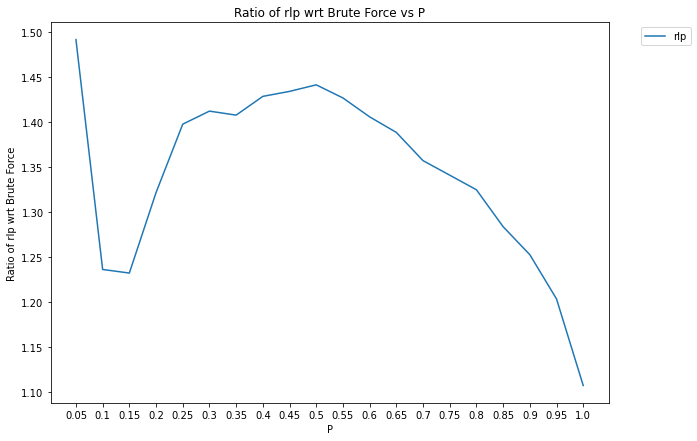

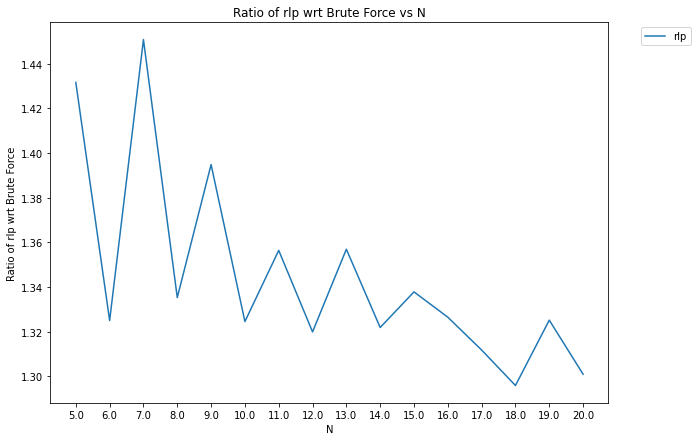

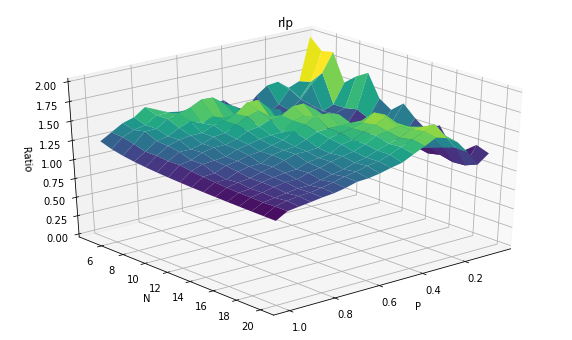

In [22]:
compare_brute_lp(5,20,0.05,1,0.05,lp = "rlp")

## Comparision of Approx Algos using RLP


 Ratio of Vertex Covers vs P
-----------------------------------------------
|    P |       g1 |       g2 |       mm |       ra |
|------|----------|----------|----------|----------|
| 0.05 | 1.01051  | 0.798503 | 1.50529  | 0.92511  |
| 0.1  | 1.21154  | 0.940905 | 1.69114  | 1.10419  |
| 0.15 | 1.15088  | 0.931712 | 1.5828   | 1.06644  |
| 0.2  | 1.04971  | 0.844916 | 1.39399  | 0.966662 |
| 0.25 | 1.0102   | 0.809567 | 1.30074  | 0.924167 |
| 0.3  | 0.982582 | 0.818395 | 1.25244  | 0.911429 |
| 0.35 | 0.982018 | 0.818348 | 1.21369  | 0.913377 |
| 0.4  | 0.959679 | 0.81023  | 1.15073  | 0.897499 |
| 0.45 | 0.950338 | 0.804389 | 1.11255  | 0.890237 |
| 0.5  | 0.917118 | 0.80217  | 1.05161  | 0.873451 |
| 0.55 | 0.916242 | 0.811565 | 1.02644  | 0.872686 |
| 0.6  | 0.910257 | 0.811689 | 1.00866  | 0.877234 |
| 0.65 | 0.912602 | 0.820626 | 0.999203 | 0.882602 |
| 0.7  | 0.916674 | 0.826479 | 0.987775 | 0.885827 |
| 0.75 | 0.905216 | 0.831835 | 0.967094 | 0.882891 |
| 0.8  | 0.906109 | 0

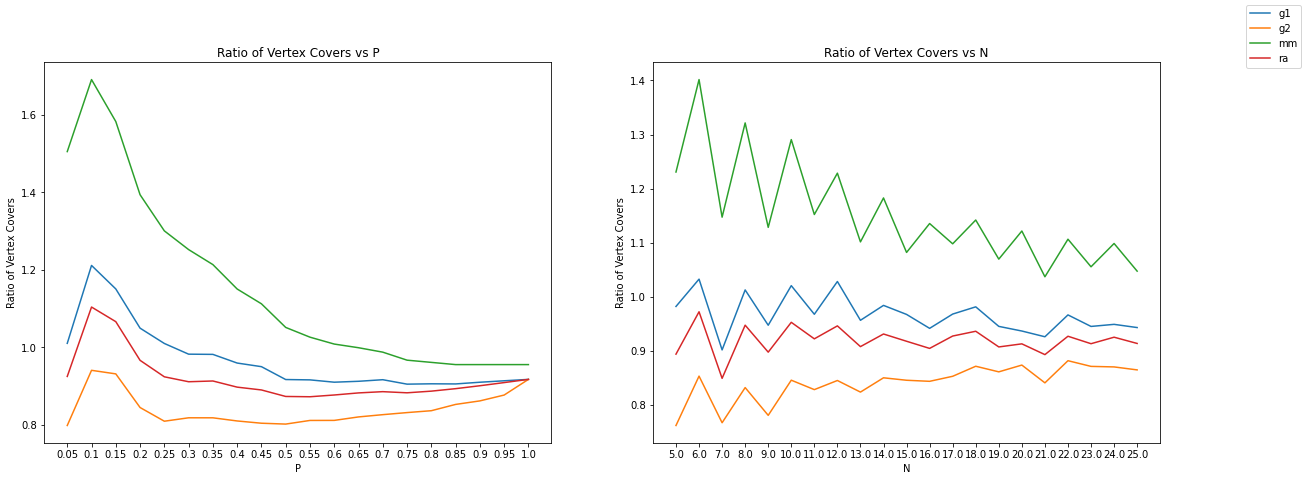

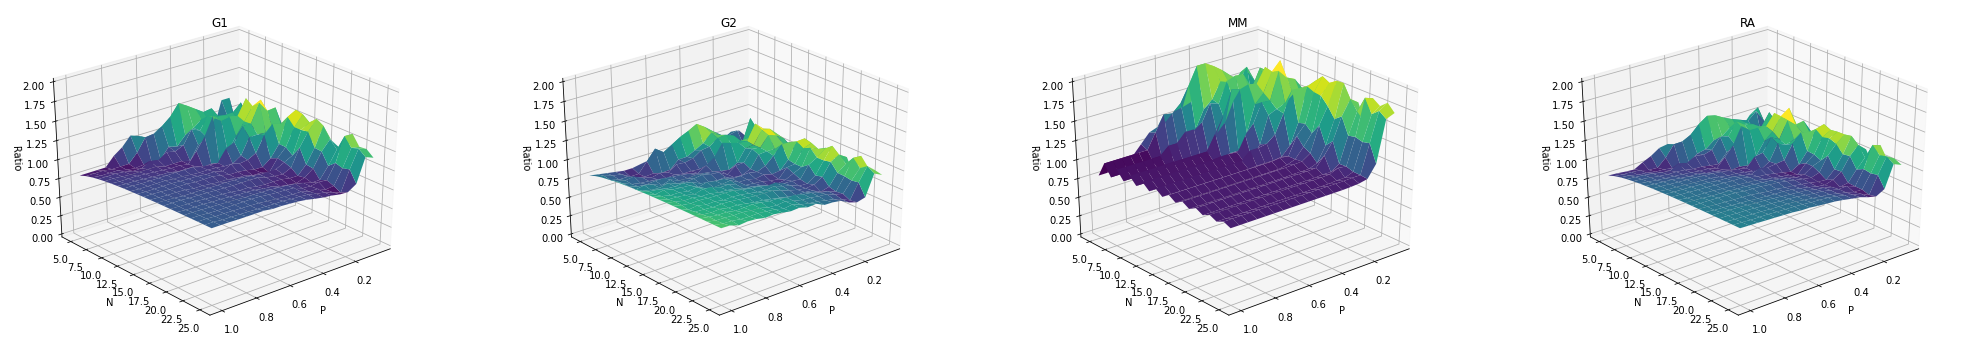

In [23]:
compare_n_p_plot(5,25,0.05,1,0.05,lp = "rlp")

----------------------------------Comparision of Algorithms----------------------------------
| Algorithms       | Vertex Covers                          |   Length |   Ratio wrt Brute Force |
|------------------|----------------------------------------|----------|-------------------------|
| Relaxed Lin Prog | [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] |       12 |                1        |
| G1 Algo          | [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]         |       10 |                0.833333 |
| G2 Algo          | [9, 0, 3, 2, 4, 5, 10, 7, 8]           |        9 |                0.75     |
| MM Algo          | [11, 7, 9, 3, 10, 6, 1, 5, 0, 2, 8, 4] |       12 |                1        |
| RA Algo          | [2, 0, 1, 4, 5, 7, 3, 9, 10, 8]        |       10 |                0.797222 |
---------------------------------------------------------------------------------------------


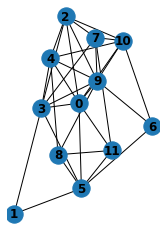

In [24]:
_,_,_,_ = compare(example_graph_object, RUNS_FOR_RA = 30, PRINT = True, lp = "rlp")

# Integer Linear Programming

----------------------------------Comparision of Algorithms----------------------------------
| Algorithms       | Vertex Covers                          |   Length |   Ratio wrt Brute Force |
|------------------|----------------------------------------|----------|-------------------------|
| Integer Lin Prog | [2, 3, 4, 5, 9, 10, 11]                |        7 |                 1       |
| G1 Algo          | [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]         |       10 |                 1.42857 |
| G2 Algo          | [9, 0, 3, 2, 4, 5, 10, 7, 8]           |        9 |                 1.28571 |
| MM Algo          | [11, 7, 9, 3, 10, 6, 1, 5, 0, 2, 8, 4] |       12 |                 1.71429 |
| RA Algo          | [0, 3, 5, 4, 7, 9, 2, 10, 8]           |        9 |                 1.40952 |
---------------------------------------------------------------------------------------------


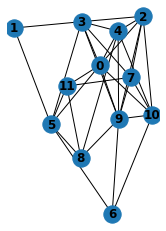

In [25]:
def ilp(graph_object, weights):
    m = Model("ILP-Vertex Cover")
    E = list(graph_object.edges())
    graph = nx.to_dict_of_lists(graph_object)
    n = len(graph.keys())

    x = [m.add_var(var_type=BINARY) for i in range(n)]

    if len(weights) == 0:
        for i in range(n):
            weights.append(1)
    m.objective = minimize(xsum(x[i]*weights[i] for i in range(n)))


    for edge in E:
        m += (x[edge[0]] + x[edge[1]]) >= 1

    m.optimize()

    vertex_cover = [i for i in range(n) if x[i].x >= 0.99]
    return vertex_cover

_,_,_,_ = compare(example_graph_object, RUNS_FOR_RA = 30, PRINT = True, lp = "ilp")

## Comparision of Approx Algos using ILP


 Ratio of Vertex Covers vs P
-----------------------------------------------
|    P |      g1 |      g2 |      mm |      ra |
|------|---------|---------|---------|---------|
| 0.05 | 1.28863 | 1.04553 | 1.98912 | 1.1936  |
| 0.1  | 1.38449 | 1.08742 | 1.95938 | 1.26652 |
| 0.15 | 1.37431 | 1.12622 | 1.89724 | 1.27836 |
| 0.2  | 1.36848 | 1.12272 | 1.821   | 1.26893 |
| 0.25 | 1.36993 | 1.11732 | 1.75977 | 1.26502 |
| 0.3  | 1.3435  | 1.13587 | 1.69772 | 1.25834 |
| 0.35 | 1.33325 | 1.12626 | 1.6336  | 1.24495 |
| 0.4  | 1.31855 | 1.12363 | 1.5687  | 1.23572 |
| 0.45 | 1.30716 | 1.1159  | 1.52051 | 1.22961 |
| 0.5  | 1.27037 | 1.1171  | 1.4524  | 1.2149  |
| 0.55 | 1.25689 | 1.1171  | 1.40614 | 1.19936 |
| 0.6  | 1.2341  | 1.10184 | 1.36809 | 1.18936 |
| 0.65 | 1.22075 | 1.09743 | 1.33783 | 1.18265 |
| 0.7  | 1.20068 | 1.08117 | 1.2958  | 1.16394 |
| 0.75 | 1.17393 | 1.0753  | 1.25802 | 1.14609 |
| 0.8  | 1.16071 | 1.06705 | 1.23392 | 1.13776 |
| 0.85 | 1.13086 | 1.06079 | 1.19487 | 1

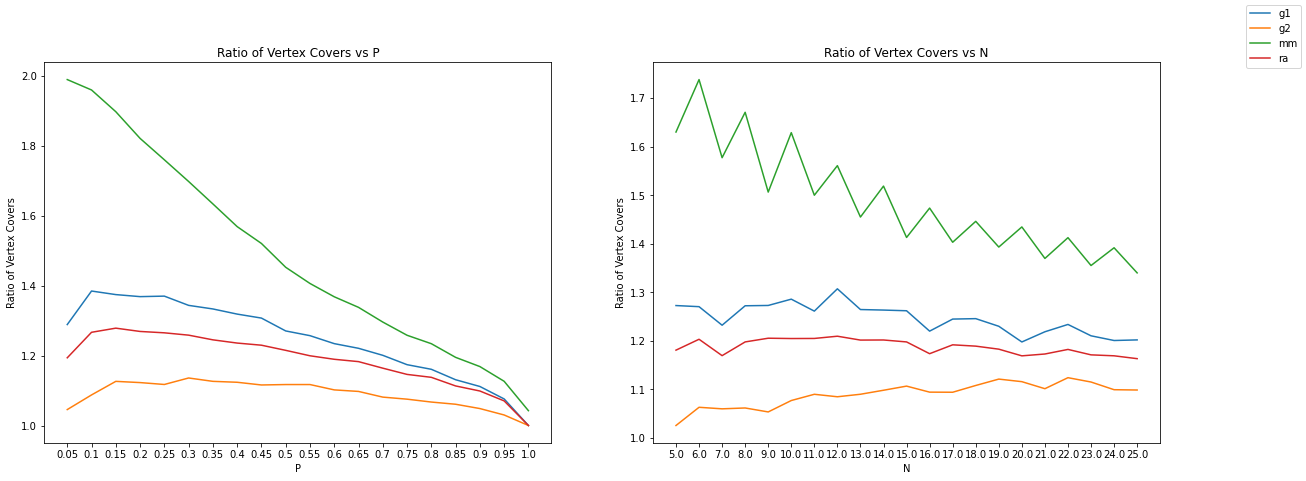

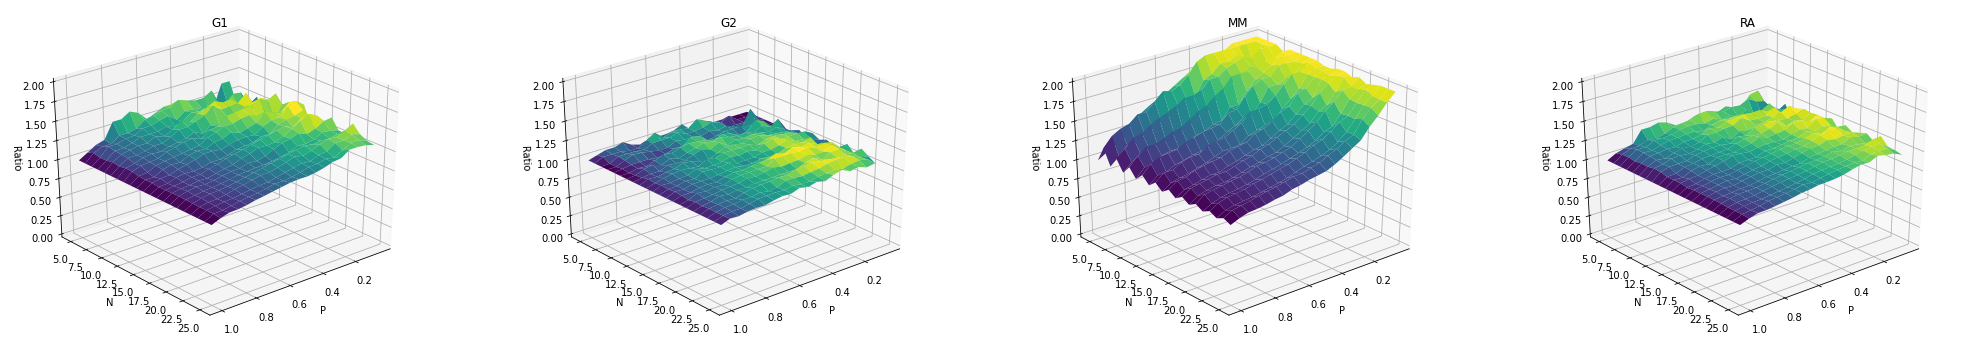

In [26]:
compare_n_p_plot(5,25,0.05,1,0.05,lp = "ilp")

# Weighted Vertex Cover

RLP Vertex Cover: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] Sum: 66
ILP Vertex Cover: [2, 3, 4, 5, 9, 10, 11] Sum: 44


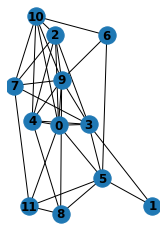

In [27]:
MIN_WEIGHT = 1
MAX_WEIGHT = 25
example_weights = [random.randint(MIN_WEIGHT,MAX_WEIGHT) for i in range(example_n)]
plot_graph(example_graph_object)
weighted_vertex_cover_rlp = rlp(example_graph_object,example_weights)
print("RLP Vertex Cover:",weighted_vertex_cover_rlp,"Sum:",sum(weighted_vertex_cover_rlp))
weighted_vertex_cover_ilp = ilp(example_graph_object,example_weights)
print("ILP Vertex Cover:",weighted_vertex_cover_ilp,"Sum:",sum(weighted_vertex_cover_ilp))

In [28]:
def compare_weighted_rlp_ilp(n_start,n_end,p_start,p_end,p_increment,MIN_WEIGHT = 1,MAX_WEIGHT = 25):
    ns = []
    lp_ratios = []
    for n in range(n_start,n_end+1):
        p = p_start
        lp_ratios_p = []
        while (p <= p_end+0.01):
            lp_ratio_sum = 0
            no = 0
            for seed in range(1,11):
                graph_object = nx.gnp_random_graph(n, p, seed, directed = False)
                weights = []
                weights = [random.randint(MIN_WEIGHT,MAX_WEIGHT) for i in range(n)]
                rlp_vertex_cover = rlp(graph_object,weights)
                ilp_vertex_cover = ilp(graph_object,weights)
                
                if len(rlp_vertex_cover) == 0 or len(ilp_vertex_cover) == 0:
                    continue
                lp_ratio = len(rlp_vertex_cover)/len(ilp_vertex_cover)
                lp_ratio_sum += lp_ratio

                if (lp_ratio != 0):
                    no += 1

            p += p_increment
            lp_ratios_p.append(lp_ratio_sum/no)
        ns.append(n)
        lp_ratios.append(lp_ratios_p)

    ps = np.linspace(0.05, 1, num = 20)
    lp_ratios = np.array(lp_ratios)

    lp_ratios_p = np.sum(lp_ratios,axis=0)/len(lp_ratios)
    
    lp_ratios_n = np.sum(lp_ratios,axis=1)/len(lp_ratios[0])

    ratios_p = {"rlp/ilp":lp_ratios_p}
    ratios_n = {"rlp/ilp":lp_ratios_n}
    plot_ratio("P",ratios_p,ps,"Weighted RLP/ILP")
    plot_ratio("N",ratios_n,ns,"Weighted RLP/ILP")

    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1, 1, 1,projection='3d')
    plot_3d("Weighted RLP/ILP",ps,ns,lp_ratios,ax1,2)
    fig.show()


 Weighted RLP/ILP vs P
-----------------------------------------------
|    P |   rlp/ilp |
|------|-----------|
| 0.05 |   1.02293 |
| 0.1  |   1.03446 |
| 0.15 |   1.1302  |
| 0.2  |   1.2188  |
| 0.25 |   1.28652 |
| 0.3  |   1.34073 |
| 0.35 |   1.35454 |
| 0.4  |   1.34542 |
| 0.45 |   1.31878 |
| 0.5  |   1.33245 |
| 0.55 |   1.33112 |
| 0.6  |   1.302   |
| 0.65 |   1.30947 |
| 0.7  |   1.28979 |
| 0.75 |   1.24998 |
| 0.8  |   1.2382  |
| 0.85 |   1.21589 |
| 0.9  |   1.20396 |
| 0.95 |   1.16386 |
| 1    |   1.09251 |

 Weighted RLP/ILP vs N
-----------------------------------------------
|   N |   rlp/ilp |
|-----|-----------|
|   5 |   1.17375 |
|   6 |   1.21692 |
|   7 |   1.22978 |
|   8 |   1.21173 |
|   9 |   1.23704 |
|  10 |   1.24702 |
|  11 |   1.24959 |
|  12 |   1.25469 |
|  13 |   1.26163 |
|  14 |   1.25101 |
|  15 |   1.26312 |
|  16 |   1.23798 |
|  17 |   1.26536 |
|  18 |   1.24963 |
|  19 |   1.25752 |
|  20 |   1.23884 |
|  21 |   1.26395 |
|  22 |   1.23

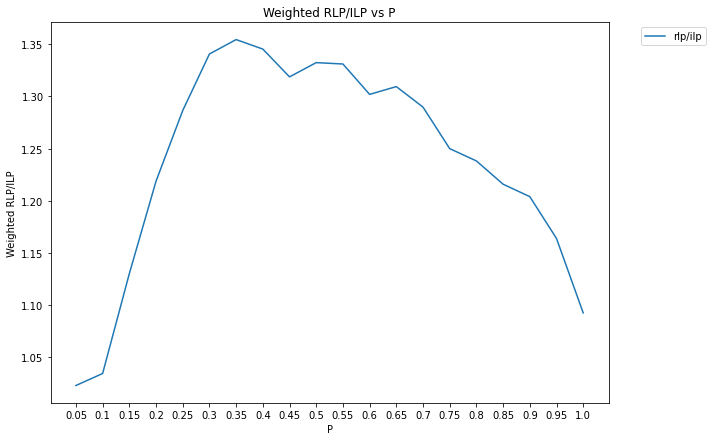

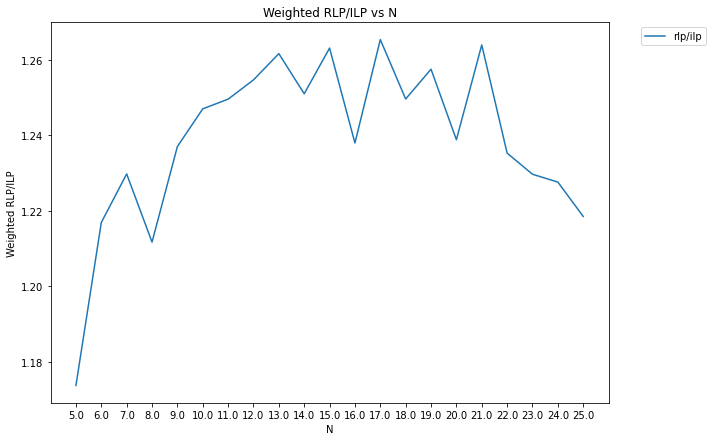

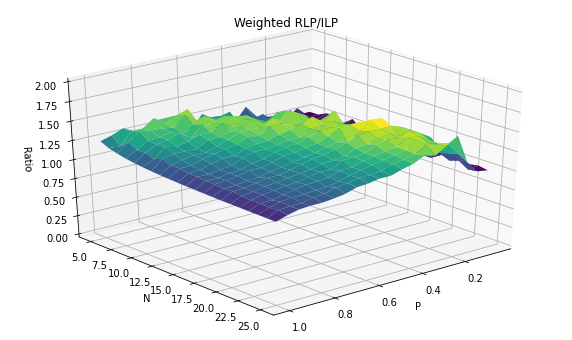

In [29]:
compare_weighted_rlp_ilp(5,25,0.05,1,0.05,1,25)